In [22]:
from math import sqrt
import matplotlib.pyplot as plt
import torch
from torchfem import Tria1
from torchfem.io import import_mesh

from global_constants import EPS0, LBD, MU, B0, L, R, RATIO

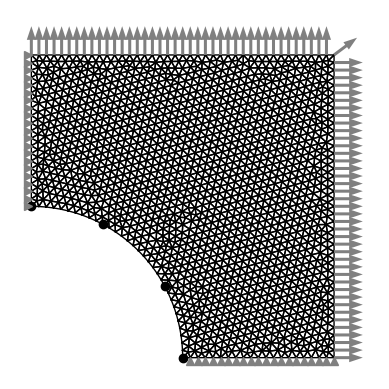

In [23]:
E = MU*(3.0*LBD+2*MU)/(LBD*MU)
nu = LBD/(2.0*(LBD+MU))
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
    [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
)

# Import mesh
domain = import_mesh("mesh.vtk", C)

# Constrain left boundary
left = domain.nodes[:, 0] == 0.0
domain.constraints[left, 0] = True

# Constrain bottom boundary
bottom = domain.nodes[:, 1] == 0.0
domain.constraints[bottom, 1] = True

# Force at right boundary
right = domain.nodes[:, 0] == L 
domain.forces[right, 0] = 0.01
domain.forces[3, 0] = 0.005
domain.forces[4, 0] = 0.005

# Force at top boundary
top = domain.nodes[:, 1] == L 
domain.forces[top, 1] = 0.01 * RATIO
domain.forces[3, 1] = 0.005 * RATIO
domain.forces[2, 1] = 0.005 * RATIO

# Control nodes
control_nodes = [0, 1, 14, 26]

# Plot the domain
domain.plot()

# Plot control nodes
cx = domain.nodes[control_nodes, 0]
cy = domain.nodes[control_nodes, 1]
plt.scatter(cx, cy, marker="o", color="black")

tensor(1.3681)


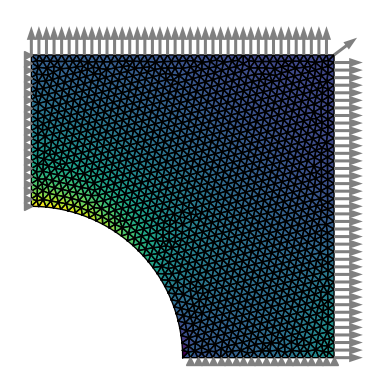

In [24]:
elem = Tria1()

def mises_stress(u):
    mises = []
    for element in domain.elements:
        # Extract node positions of element
        xe = domain.nodes[element, :]

        # Extract displacement degrees of freedom
        ue = u[element, :].ravel()

        # Set position of evaluation
        xi = [0.0, 0.0]

        # Jacobian
        J = elem.B(xi) @ xe

        # Compute B
        B = torch.linalg.inv(J) @ elem.B(xi)
        zeros = torch.zeros(elem.nodes)

        # Compute D
        D0 = torch.stack([B[0, :], zeros], dim=-1).ravel()
        D1 = torch.stack([zeros, B[1, :]], dim=-1).ravel()
        D2 = torch.stack([B[1, :], B[0, :]], dim=-1).ravel()
        D = torch.stack([D0, D1, D2])

        # Compute stress
        s = C @ D @ ue
        mises.append(torch.sqrt(s[0] ** 2 + s[1] ** 2 - s[0] * s[1] + 3 * s[2] ** 2))
    return torch.stack(mises)


# Plot the results
u, f = domain.solve()
stress = mises_stress(u)
domain.plot(element_property=stress)
print(max(mises_stress(u)))

In [25]:
epsilon = 3.0
r = torch.cdist(domain.nodes, domain.nodes)
phi = torch.exp(-((epsilon * r) ** 2))

def morph(fem, nids, x, dir):
    # Build matrix
    M = phi[:, nids]
    M = M[nids, :]

    # Solve linear equation system
    weights = torch.linalg.solve(M, x - fem.nodes[nids, dir])

    # Apply deformation
    for weight, node in zip(weights, nids):
        fem.nodes[:, dir] += weight * phi[node, :]

In [26]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
    return x


def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    f_k = func(x_k)

    def approximation(x):
        res = f_k * torch.ones_like(x[..., 0])
        for j, grad in enumerate(grads):
            if grad < 0.0:
                p = 0
                q = -((x_k[j] - L_k[j]) ** 2) * grad
            else:
                p = (U_k[j] - x_k[j]) ** 2 * grad
                q = 0
            res -= p / (U_k[j] - x_k[j]) + q / (x_k[j] - L_k[j])
            res += p / (U_k[j] - x[..., j]) + q / (x[..., j] - L_k[j])
        return res

    return approximation

In [27]:
def f(x):
    # Update nodes
    morph(domain, control_nodes, x[0::2], 0)
    morph(domain, control_nodes, x[1::2], 1)
    # Solve fem with updated nodes
    u_k, f_k = domain.solve()
    # Compute stress
    stress = mises_stress(u_k)
    # Return top 5 stresses
    top5 = torch.topk(stress, 5)[0]
    return top5.sum()

In [28]:
def optimize(x_0, x_min, x_max, iter):
    s = 0.5

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]
    objective = [f(x_0)]

    for k in range(iter):
        # Update asymptotes with heuristic procedure (see Exercise 04)
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde = MMA(f, x[k], L[k], U[k])

        # Compute the maximum of the dual function
        x_star = box_constrained_decent(f_tilde, x_0, x_min_k, x_max_k, eta=0.1)

        # Compute current optimal point with dual solution
        x.append(x_star)
        objective.append(f(x_star).detach())

    return x, objective

In [29]:
# Bounds on variables
x_0 = domain.nodes[control_nodes, :].ravel()
x_min = x_0 - 0.1
x_max = x_0 + 0.1

# Fix left node in horizontal direction and right node in vertical direction
eps = 0.0001
x_min[0] = -eps
x_min[3] = -eps
x_max[0] = eps
x_max[3] = eps

x_opt, f_opt = optimize(x_0, x_min, x_max, 15)

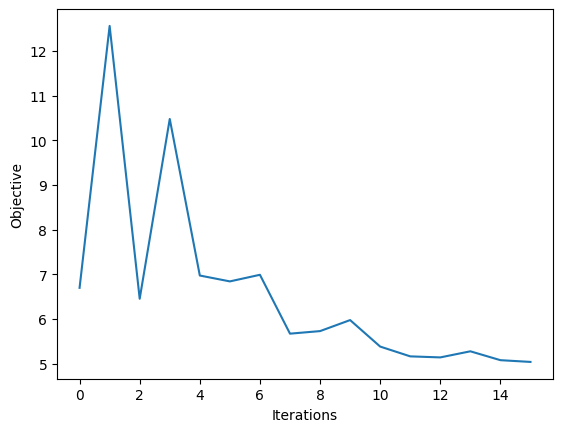

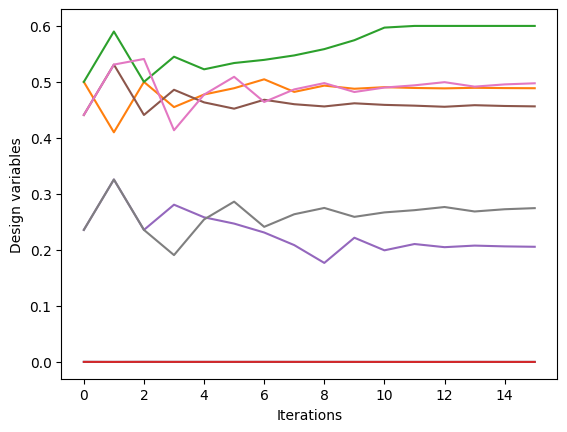

In [30]:
plt.plot(f_opt)
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.show()
plt.plot(torch.stack(x_opt).detach())
plt.xlabel("Iterations")
plt.ylabel("Design variables")
plt.show()

tensor(1.0154, grad_fn=<UnbindBackward0>)


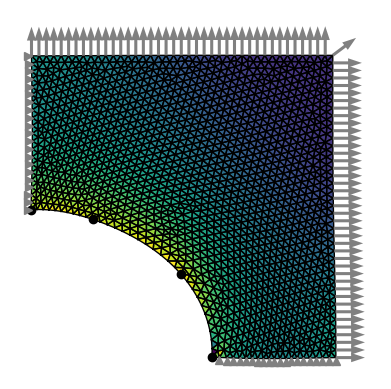

In [31]:
u, f = domain.solve()
stress = mises_stress(u)

domain.plot(element_property=stress)
plt.scatter(
    domain.nodes[control_nodes, 0].detach(),
    domain.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)
print(max(mises_stress(u)))